#Demo for time-series load_dataset functions
ts_load_dataset_demo.ipynb

This is a brief demo and simple test of the load_dataset functions that convert the raw datasets into useable ndarrays. 
* Gets the numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates a 1D-CNN classifier for the selected dataset
* Displays model evaluation metrics and a confusion matrix

Comments:  MobiAct and UniMiB SHAR accuracies exceed 90% using total acceleration, UCI HAR and e4_Nov2019 have difficulty with standing/laying/sitting so component acceleration is included which increases overall accruacies.   This may not generalize well if the training set does not include a case where the device orientation is similar to the test case.  i.e. using component accel introduces orientation "awareness" and may hurt generalization.
The e4 data set is very small making it easy to experiment with but the loss curves will not be nearly as uniform and it is easy to overfit the data. 

Important Note: This uses the test sets - if you are still tuning your model be very careful not to inadvertently incorporate knowledge of the test set in your experiments.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* This version is work-in-progress to run without drive mount on public repo, TWristAR and Gesture-Phase-Signing have been tested.
* Make a run-all option or ability to select more than one dataset.
* Refactor the model and training to support more than one model.

#Imports

In [1]:
import os
import shutil
import urllib.request # to get files from web w/o !wget
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves

# to measure and display training time
import time
from datetime import timedelta

# model library and functions
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping

# for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# temp - needed for SHL split
from sklearn.model_selection import train_test_split

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')

In [3]:
import load_data_utils as utils
print(utils.get_env_info())

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 525.85.12, 15360 MiB



In [5]:
#@title Select Dataset
dataset = "TWristAR" #@param ["MobiAct HAR", "UniMiB SHAR","UCI HAR","TWristAR","Leotta_2021","SHL","Gesture Phase Segmentation"]

print("Using",dataset,"dataset")
if (dataset == 'Leotta_2021'):
    print ("NOTE: this dataset requires a high-RAM runtime on colab")

Using TWristAR dataset


#Get numpy arrays from load_dataset

In [6]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
if (dataset == 'MobiAct HAR'):
    !gdown "1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t" # MobiAct alternate file source
    # original share is https://drive.google.com/uc?id=0B5VcW5yHhWhibWxGRTZDd0dGY2s'
    # please see https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/ if not working
    get_py_file(fname = 'mobiact_adl_load_dataset.py', 
            url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/MobiAct/mobiact_adl_load_dataset.py')
    from mobiact_adl_load_dataset import mobiact_adl_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
    k_size = 50
    EPOCHS = 50
    t_names = ['JOG','JUM','STD','STN','STU','WAL']
elif (dataset == 'UniMiB SHAR'):
    get_py_file(fname = 'unimib_adl_load_dataset.py', 
            url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UniMiB_SHAR/unimib_shar_adl_load_dataset.py')
    from unimib_adl_load_dataset import unimib_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
    t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
    k_size = 50
    EPOCHS = 60
elif (dataset == 'UCI HAR'):
    get_py_file(fname = 'uci_har_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UCI_HAR/uci_har_load_dataset.py')
    from uci_har_load_dataset import uci_har_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
    t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    k_size = 50
    EPOCHS = 120
elif (dataset == 'TWristAR'):
    # Note TWristAR is more updated than the previous datasets so the accesses
    # and defaults are a bit different, e.g. t_names is pulled from the .py
    get_py_file(fname = 'twristar_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
    import twristar_load_dataset as twristar_load_dataset # diff to get label map
    x_train, y_train, x_valid, y_valid, x_test, y_test \
                             = twristar_load_dataset.twristar_load_dataset(
                                 incl_val_group = True,
                                 one_hot_encode = True)
    t_names = list(twristar_load_dataset.label_map_twristar.get('label').keys())
    t_names.remove('Undefined')
    k_size = 16
    EPOCHS = 100
elif (dataset == 'Leotta_2021'):
    get_py_file(fname = 'leotta_2021_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/Leotta_2021/leotta_2021_load_dataset.py')
    #full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
    #shutil.copy(full_filename,'leotta_2021_load_dataset.py')
    import leotta_2021_load_dataset as leotta_2021_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info = leotta_2021_load_dataset.leotta_2021_load_dataset(incl_val_group = True)
    # Note:  OTHER referenced in readme.txt was deleted during the processing,
    # and the one-hot encoding shifted everything by one, hence RELAX = 0 now
    t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
                'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
                'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
                'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
    k_size = 100
    EPOCHS = 50
elif (dataset == 'SHL'):
    # SHL takes about 30 minutes to process due to size, using saved arrays for now
    !gdown "1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t" # SHL 20Hz
    utils.unzip_into_dir('SHL_20hz_for_gentry.zip','SHL')
    input_dir = './SHL'
    x_train = np.load(input_dir + '/'+'x_train.npy')
    x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
    x_test = np.load(input_dir + '/'+'x_test.npy')
    x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
    y_train = np.load(input_dir + '/'+'y_train.npy')
    y_test = np.load(input_dir + '/'+'y_test.npy')
    # also don't have validate working in SHL so just using stratify
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

    t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
    k_size = 15
    EPOCHS = 100
elif (dataset == 'Gesture Phase Segmentation'):
    get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
    from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = gesture_phase_segmentation_load_dataset(
                                 incl_val_group = True,
                                 return_info_dict = True)
    print("Note: Due to the size of the Gesture Phase Segmentation and for",
          "\ncompatibility, the test arrays are copies of the valid arrays")
    x_test = x_valid.copy()
    y_test = y_valid.copy()
    t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
    k_size = 9
else:
    print('ERROR: dataset unknown')
print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                   'x_valid':x_valid,'y_valid':y_valid,
                                   'x_test':x_test,'y_test':y_test}))    

Unzipping TWristAR file in . directory
90/10 split of the training group.  It is not subject independent.
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test   (1091, 6)      uint8


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#Build a 1D CNN model
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [7]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
def build_1D_CNN():
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
      layers.Dropout(0.5),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(100, activation='relu'),
      layers.Dense(n_outputs, activation='softmax')
        ])
  return model 
model = build_1D_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 81, 100)           1700      
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 100)           160100    
                                                                 
 dropout (Dropout)           (None, 66, 100)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 100)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3300)              0         
                                                                 
 dense (Dense)               (None, 100)               330100    
                                                        

#Train the model

In [8]:
def train_1D_CNN(model,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=7)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=(x_valid,y_valid),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history
start_time = time.time()
history = train_1D_CNN(model)
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')

Epoch 1/100
59/59 [==============================] - 11s 14ms/step - loss: 1.0028 - accuracy: 0.5270 - val_loss: 0.6385 - val_accuracy: 0.6875
Epoch 2/100
59/59 [==============================] - 0s 5ms/step - loss: 0.5491 - accuracy: 0.7138 - val_loss: 0.5082 - val_accuracy: 0.7837
Epoch 3/100
59/59 [==============================] - 0s 5ms/step - loss: 0.4430 - accuracy: 0.7485 - val_loss: 0.3860 - val_accuracy: 0.8269
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 0.3631 - accuracy: 0.8031 - val_loss: 0.3729 - val_accuracy: 0.8125
Epoch 5/100
59/59 [==============================] - 0s 5ms/step - loss: 0.3318 - accuracy: 0.8063 - val_loss: 0.3675 - val_accuracy: 0.7837
Epoch 6/100
59/59 [==============================] - 0s 5ms/step - loss: 0.3287 - accuracy: 0.8154 - val_loss: 0.4417 - val_accuracy: 0.7644
Epoch 7/100
59/59 [==============================] - 0s 5ms/step - loss: 0.2963 - accuracy: 0.8240 - val_loss: 0.3577 - val_accuracy: 0.8365
Epoch 8/100

#Show Final Validation Accuracy and Loss Curve 

TWristAR 1D CNN Final Validation Accuracy: 0.832


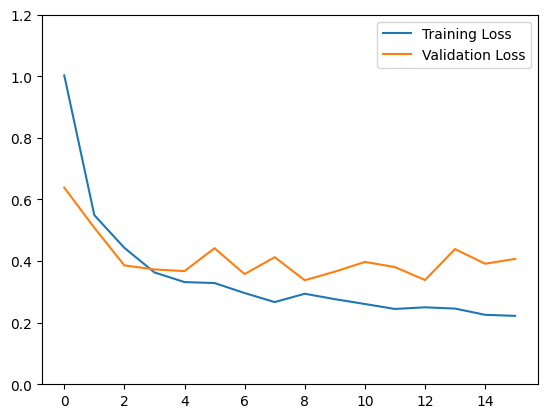

In [9]:
print(dataset, "1D CNN ", end = '')
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0,1.2]) #for consistency - 1.2 has been a good value experimentally
plt.legend()
plt.show()

# Run the model - predict using the test data

1D CNN using TWristAR - Prediction Accuracy: 0.687
              precision    recall  f1-score   support

  Downstairs       0.97      0.50      0.66       173
     Jogging       0.98      0.50      0.66       173
     Sitting       1.00      0.35      0.51       171
    Standing       0.62      0.96      0.76       186
    Upstairs       0.58      0.99      0.74       198
     Walking       0.61      0.75      0.67       190

    accuracy                           0.69      1091
   macro avg       0.79      0.68      0.67      1091
weighted avg       0.78      0.69      0.67      1091



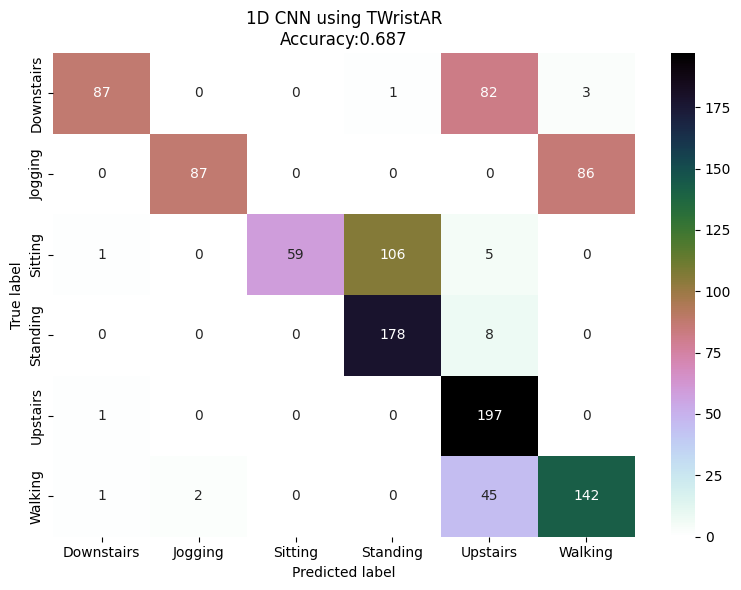

In [10]:
predictions = model.predict(x_test, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
print("1D CNN using " + dataset + ' - Prediction Accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
#return (accuracy_score(y_temp, y_pred)),y_pred
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
print(classification_report(y_test_act, y_pred, target_names=t_names))
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(8,6)) # num classes => size
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()